In [1]:
FASTPROGRESS = True

In [2]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2
import subprocess as sp
if FASTPROGRESS:
    from fastprogress.fastprogress import master_bar, progress_bar
else:
    from tqdm import tqdm

In [3]:
SEARCH_BS = False
SEARCH_LR = False

In [4]:
division = 300
resize_img = 500
BS_train = 16
if SEARCH_LR:
    BS_train = int(BS_train / 2)
BS_val = BS_train * 4
EPOCHS = 400
LR = 1e-2
NOTEBOOK_NAME = '08_Resnet18_finders_and_fastprogress'

In [5]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv']

In [6]:
train_images_path = data_path / "train_images"

In [7]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## ResNet 50 UNet

In [8]:
number_of_classes = 2 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        # x_in = torch.tensor(x.clone().detach())
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

## Dice coefficient loss

In [9]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Dataset and Dataloader

In [10]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [11]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [12]:
dataset = {
    'train': Dataset(train_df[:division], n_classes=2, dim=resize_img),
    'val': Dataset(train_df[division:], n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 300 imágenes de entrenamiento y 51 imágenes de validación


In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

## Batch size finder

In [14]:
if SEARCH_BS:
    def get_gpu_memory():
        command = "nvidia-smi --query-gpu=memory.total --format=csv"
        memory_total_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_total_values = [int(x.split()[0]) for i, x in enumerate(memory_total_info)]

        command = "nvidia-smi --query-gpu=memory.free --format=csv"
        memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]

        command = "nvidia-smi --query-gpu=memory.used --format=csv"
        memory_used_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_used_values = [int(x.split()[0]) for i, x in enumerate(memory_used_info)]
        return memory_total_values, memory_free_values, memory_used_values
    total, free, used = get_gpu_memory()
    print(f"GPU memory: total: {total} MiB, free: {free} MiB, used: {used} MiB")

In [15]:
if SEARCH_BS:
    model = UNetResnet()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [16]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [17]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [18]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    BSs

In [19]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                print(f'Error: {e}')
                out_of_memory = True
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [20]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [21]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [22]:
if SEARCH_LR:
    model = UNetResnet()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [23]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [24]:
if FASTPROGRESS:
    def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
        """ dynamically print the loss plot during the training/validation loop.
            expects epoch to start from 1.
        """
        x = range(1, epoch+1)
        y = np.concatenate((train_loss, valid_loss))
        graphs = [[x,train_loss], [x,valid_loss]]
        x_margin = 0.2
        y_margin = 0.05
        x_bounds = [1-x_margin, epochs+x_margin]
        y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

        mb.update_graph(graphs, x_bounds, y_bounds)

In [25]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    model_folder = path/'models'
    model_full_name = model_folder/ NOTEBOOK_NAME
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=0.1, 
        patience=10, 
        verbose=True)
    # mb = master_bar(range(1, epochs+1))
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': []}
    for epoch in range(epochs):
        bar = tqdm(dataloader['train'])
        train_loss, train_dice = [], []
        model.train()
        # for (imgs, masks) in progress_bar(dataloader['train'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update train loss and dice
            dice = dice_coeff(pred_mask, masks)
            train_loss.append(loss.item())
            train_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
            # mb.child.comment = f'train loss: {loss.item():>7f}'
        hist['loss'].append(np.mean(train_loss))
        hist['dice'].append(np.mean(train_dice))
        bar = tqdm(dataloader['val'])
        val_loss, val_dice = [], []
        model.eval()
        with torch.no_grad():
            # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
            for imgs, masks in bar:
                # X and y to device
                imgs, masks = imgs.to(device), masks.to(device)
                # Compute prediction and loss
                pred_mask = model(imgs)
                loss = criterion(pred_mask, masks)
                # Update test loss and dice
                dice = dice_coeff(pred_mask, masks)
                val_loss.append(loss.item())
                val_dice.append(dice)
                # Update progress bar
                bar.set_description(f"\t\tval_loss {np.mean(val_loss):.5f} test_dice {np.mean(val_dice):.5f}")
                # mb.child.comment = f'val_loss: {np.mean(val_loss):>7f}, cortest_dicerect: {np.mean(val_dice):>7f}'
        hist['val_loss'].append(np.mean(val_loss))
        hist['val_dice'].append(np.mean(val_dice))
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} val_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} val_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} val_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} val_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
        
        # mb.main_bar.comment = f'epoch: {epoch}+1/{epochs}, loss: {np.mean(train_loss):>7f}, dice: {np.mean(train_dice):>7f},  val_loss {np.mean(val_loss):.7f}, val_dice {np.mean(val_dice):.7f}'
        # mb.write(f'epoch: {epoch}, loss: {np.mean(train_loss):>7f}, dice: {np.mean(train_dice):>7f},  val_loss {np.mean(val_loss):.7f}, val_dice {np.mean(val_dice):.7f}')
        # plot_loss_update(epoch, epochs, mb, train_loss, val_loss)

        if np.mean(val_dice) > best_dice:
            best_dice = np.mean(val_dice)
            model_full_path = model_full_name.with_suffix('.pth')
            torch.save(model.state_dict(), model_full_path)
            print(f"New best dice: {best_dice:.5f}")
            # mb.child.comment = f'New best dice: {best_dice:.5f}'
        
        schedulerOnPlateau.step(np.mean(val_loss))
    return hist

In [26]:
if not SEARCH_BS and not SEARCH_LR:
    model = UNetResnet()
    hist = fit(model, dataloader, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		val_loss 1.47237 test_dice 20.05175: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Epoch 001/400 loss 0.34226 dice 3.56593 val_loss 1.47237 val_dice 20.05175
New best dice: 20.05175


		val_loss 0.29038 test_dice 17.30945: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Epoch 002/400 loss 0.27352 dice 7.17421 val_loss 0.29038 val_dice 17.30945


		val_loss 0.26980 test_dice 6.25832: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 003/400 loss 0.25553 dice 7.00523 val_loss 0.26980 val_dice 6.25832


		val_loss 0.43229 test_dice 1.39615: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 004/400 loss 0.25346 dice 7.03393 val_loss 0.43229 val_dice 1.39615


		val_loss 0.46603 test_dice 1.17941: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 005/400 loss 0.25023 dice 6.99457 val_loss 0.46603 val_dice 1.17941


		val_loss 0.40970 test_dice 1.63547: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 006/400 loss 0.25017 dice 6.75146 val_loss 0.40970 val_dice 1.63547


		val_loss 0.51514 test_dice 0.88778: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 007/400 loss 0.24432 dice 6.89999 val_loss 0.51514 val_dice 0.88778


		val_loss 0.48658 test_dice 1.40358: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Epoch 008/400 loss 0.23941 dice 6.93704 val_loss 0.48658 val_dice 1.40358


		val_loss 0.31075 test_dice 7.15356: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 009/400 loss 0.27045 dice 6.52330 val_loss 0.31075 val_dice 7.15356


		val_loss 0.41846 test_dice 2.50189: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 010/400 loss 0.24263 dice 5.65295 val_loss 0.41846 val_dice 2.50189


		val_loss 0.29516 test_dice 4.83185: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 011/400 loss 0.23751 dice 6.27794 val_loss 0.29516 val_dice 4.83185


		val_loss 0.39295 test_dice 1.91265: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 012/400 loss 0.23711 dice 6.66832 val_loss 0.39295 val_dice 1.91265
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.


		val_loss 0.21451 test_dice 6.63535: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 013/400 loss 0.22404 dice 6.87174 val_loss 0.21451 val_dice 6.63535


		val_loss 0.20211 test_dice 6.77491: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 014/400 loss 0.22185 dice 6.95350 val_loss 0.20211 val_dice 6.77491


		val_loss 0.19308 test_dice 7.27876: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 015/400 loss 0.21802 dice 6.97879 val_loss 0.19308 val_dice 7.27876


		val_loss 0.19496 test_dice 7.29089: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


Epoch 016/400 loss 0.21625 dice 7.03243 val_loss 0.19496 val_dice 7.29089


		val_loss 0.19692 test_dice 7.80651: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 017/400 loss 0.21178 dice 7.09994 val_loss 0.19692 val_dice 7.80651


		val_loss 0.18964 test_dice 7.56700: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 018/400 loss 0.20860 dice 7.17948 val_loss 0.18964 val_dice 7.56700


		val_loss 0.24438 test_dice 7.72028: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 019/400 loss 0.21011 dice 7.18021 val_loss 0.24438 val_dice 7.72028


		val_loss 0.17907 test_dice 7.60100: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 020/400 loss 0.20464 dice 7.28032 val_loss 0.17907 val_dice 7.60100


		val_loss 0.18289 test_dice 7.35732: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 021/400 loss 0.20292 dice 7.36126 val_loss 0.18289 val_dice 7.35732


		val_loss 0.20193 test_dice 7.92443: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Epoch 022/400 loss 0.20025 dice 7.39505 val_loss 0.20193 val_dice 7.92443


		val_loss 0.17917 test_dice 7.68114: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 023/400 loss 0.19703 dice 7.53657 val_loss 0.17917 val_dice 7.68114
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


		val_loss 0.17519 test_dice 7.70613: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 024/400 loss 0.19712 dice 7.52783 val_loss 0.17519 val_dice 7.70613


		val_loss 0.16938 test_dice 7.79514: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 025/400 loss 0.19694 dice 7.52612 val_loss 0.16938 val_dice 7.79514


		val_loss 0.16744 test_dice 7.95103: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 026/400 loss 0.19636 dice 7.53089 val_loss 0.16744 val_dice 7.95103


		val_loss 0.16741 test_dice 7.86079: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 027/400 loss 0.19045 dice 7.56387 val_loss 0.16741 val_dice 7.86079


		val_loss 0.16690 test_dice 7.91217: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 028/400 loss 0.19421 dice 7.56743 val_loss 0.16690 val_dice 7.91217


		val_loss 0.16711 test_dice 7.89044: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 029/400 loss 0.19370 dice 7.57411 val_loss 0.16711 val_dice 7.89044


		val_loss 0.16620 test_dice 7.98791: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 030/400 loss 0.19337 dice 7.57967 val_loss 0.16620 val_dice 7.98791


		val_loss 0.16803 test_dice 7.88571: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 031/400 loss 0.19405 dice 7.57999 val_loss 0.16803 val_dice 7.88571


		val_loss 0.16620 test_dice 7.95111: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 032/400 loss 0.19291 dice 7.59916 val_loss 0.16620 val_dice 7.95111


		val_loss 0.16692 test_dice 8.03751: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 033/400 loss 0.19136 dice 7.62922 val_loss 0.16692 val_dice 8.03751


		val_loss 0.16787 test_dice 8.01091: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Epoch 034/400 loss 0.18981 dice 7.63199 val_loss 0.16787 val_dice 8.01091
Epoch 00034: reducing learning rate of group 0 to 1.0000e-05.


		val_loss 0.16766 test_dice 8.04468: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 035/400 loss 0.19266 dice 7.62951 val_loss 0.16766 val_dice 8.04468


		val_loss 0.16859 test_dice 7.92536: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 036/400 loss 0.19318 dice 7.62309 val_loss 0.16859 val_dice 7.92536


		val_loss 0.16901 test_dice 7.95613: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 037/400 loss 0.19092 dice 7.63483 val_loss 0.16901 val_dice 7.95613


		val_loss 0.16815 test_dice 7.87705: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 038/400 loss 0.19087 dice 7.62622 val_loss 0.16815 val_dice 7.87705


		val_loss 0.16818 test_dice 7.88051: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 039/400 loss 0.18816 dice 7.63991 val_loss 0.16818 val_dice 7.88051


		val_loss 0.16938 test_dice 7.81031: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Epoch 040/400 loss 0.18961 dice 7.64071 val_loss 0.16938 val_dice 7.81031


		val_loss 0.16721 test_dice 7.93949: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 041/400 loss 0.19014 dice 7.64520 val_loss 0.16721 val_dice 7.93949


		val_loss 0.16827 test_dice 7.90385: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 042/400 loss 0.19232 dice 7.63279 val_loss 0.16827 val_dice 7.90385


		val_loss 0.16767 test_dice 7.90500: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 043/400 loss 0.18814 dice 7.65398 val_loss 0.16767 val_dice 7.90500


		val_loss 0.16805 test_dice 7.84403: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 044/400 loss 0.19024 dice 7.64101 val_loss 0.16805 val_dice 7.84403


		val_loss 0.16672 test_dice 8.11613: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 045/400 loss 0.19184 dice 7.63545 val_loss 0.16672 val_dice 8.11613
Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.


		val_loss 0.16627 test_dice 8.13288: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


Epoch 046/400 loss 0.18907 dice 7.64411 val_loss 0.16627 val_dice 8.13288


		val_loss 0.16781 test_dice 7.97371: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 047/400 loss 0.19184 dice 7.63726 val_loss 0.16781 val_dice 7.97371


		val_loss 0.16635 test_dice 8.06623: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 048/400 loss 0.19646 dice 7.62071 val_loss 0.16635 val_dice 8.06623


		val_loss 0.16739 test_dice 7.95462: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 049/400 loss 0.18851 dice 7.65417 val_loss 0.16739 val_dice 7.95462


		val_loss 0.16594 test_dice 7.99779: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 050/400 loss 0.19004 dice 7.64916 val_loss 0.16594 val_dice 7.99779


		val_loss 0.16601 test_dice 7.96631: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 051/400 loss 0.19135 dice 7.63880 val_loss 0.16601 val_dice 7.96631


		val_loss 0.16724 test_dice 7.90795: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 052/400 loss 0.18940 dice 7.64752 val_loss 0.16724 val_dice 7.90795


		val_loss 0.16684 test_dice 7.96787: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 053/400 loss 0.19054 dice 7.63826 val_loss 0.16684 val_dice 7.96787


		val_loss 0.16645 test_dice 7.93519: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Epoch 054/400 loss 0.19123 dice 7.64317 val_loss 0.16645 val_dice 7.93519


		val_loss 0.16610 test_dice 8.00421: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 055/400 loss 0.19219 dice 7.63588 val_loss 0.16610 val_dice 8.00421


		val_loss 0.16866 test_dice 7.92488: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 056/400 loss 0.18821 dice 7.65303 val_loss 0.16866 val_dice 7.92488
Epoch 00056: reducing learning rate of group 0 to 1.0000e-07.


		val_loss 0.16644 test_dice 7.93016: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 057/400 loss 0.18847 dice 7.65676 val_loss 0.16644 val_dice 7.93016


		val_loss 0.16851 test_dice 7.90508: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 058/400 loss 0.19065 dice 7.63893 val_loss 0.16851 val_dice 7.90508


		val_loss 0.16803 test_dice 7.85445: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 059/400 loss 0.18946 dice 7.64568 val_loss 0.16803 val_dice 7.85445


		val_loss 0.16738 test_dice 7.88334: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 060/400 loss 0.19171 dice 7.63748 val_loss 0.16738 val_dice 7.88334


		val_loss 0.17008 test_dice 7.77145: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 061/400 loss 0.18931 dice 7.65383 val_loss 0.17008 val_dice 7.77145


		val_loss 0.16753 test_dice 7.93845: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 062/400 loss 0.18879 dice 7.65144 val_loss 0.16753 val_dice 7.93845


		val_loss 0.16710 test_dice 7.89500: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 063/400 loss 0.18748 dice 7.65605 val_loss 0.16710 val_dice 7.89500


		val_loss 0.16858 test_dice 7.88242: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 064/400 loss 0.18686 dice 7.65889 val_loss 0.16858 val_dice 7.88242


		val_loss 0.16739 test_dice 7.88899: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 065/400 loss 0.18534 dice 7.66471 val_loss 0.16739 val_dice 7.88899


		val_loss 0.16920 test_dice 7.87145: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 066/400 loss 0.19132 dice 7.64306 val_loss 0.16920 val_dice 7.87145


		val_loss 0.16845 test_dice 7.87041: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 067/400 loss 0.19151 dice 7.63921 val_loss 0.16845 val_dice 7.87041
Epoch 00067: reducing learning rate of group 0 to 1.0000e-08.


		val_loss 0.16783 test_dice 7.95266: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 068/400 loss 0.19181 dice 7.63983 val_loss 0.16783 val_dice 7.95266


		val_loss 0.16906 test_dice 7.90749: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 069/400 loss 0.19003 dice 7.64769 val_loss 0.16906 val_dice 7.90749


		val_loss 0.16730 test_dice 7.90461: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 070/400 loss 0.18877 dice 7.65048 val_loss 0.16730 val_dice 7.90461


		val_loss 0.16710 test_dice 7.89036: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 071/400 loss 0.18717 dice 7.65486 val_loss 0.16710 val_dice 7.89036


		val_loss 0.16655 test_dice 7.92080: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 072/400 loss 0.18869 dice 7.64634 val_loss 0.16655 val_dice 7.92080


		val_loss 0.16550 test_dice 7.97148: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 073/400 loss 0.19116 dice 7.64265 val_loss 0.16550 val_dice 7.97148


		val_loss 0.16572 test_dice 7.94368: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 074/400 loss 0.19177 dice 7.64227 val_loss 0.16572 val_dice 7.94368


		val_loss 0.16729 test_dice 8.02215: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 075/400 loss 0.18851 dice 7.64899 val_loss 0.16729 val_dice 8.02215


		val_loss 0.16674 test_dice 7.95663: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 076/400 loss 0.19004 dice 7.64981 val_loss 0.16674 val_dice 7.95663


		val_loss 0.16739 test_dice 7.97871: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 077/400 loss 0.18755 dice 7.64981 val_loss 0.16739 val_dice 7.97871


		val_loss 0.16649 test_dice 7.98202: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 078/400 loss 0.18789 dice 7.65061 val_loss 0.16649 val_dice 7.98202


		val_loss 0.16871 test_dice 7.90090: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 079/400 loss 0.18996 dice 7.63844 val_loss 0.16871 val_dice 7.90090


		val_loss 0.16792 test_dice 7.86219: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 080/400 loss 0.19012 dice 7.64512 val_loss 0.16792 val_dice 7.86219


		val_loss 0.16930 test_dice 7.79828: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 081/400 loss 0.18828 dice 7.65169 val_loss 0.16930 val_dice 7.79828


		val_loss 0.16764 test_dice 7.88700: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 082/400 loss 0.18732 dice 7.66117 val_loss 0.16764 val_dice 7.88700


		val_loss 0.16765 test_dice 7.92186: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 083/400 loss 0.19103 dice 7.63861 val_loss 0.16765 val_dice 7.92186


		val_loss 0.16707 test_dice 7.93752: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 084/400 loss 0.18907 dice 7.65092 val_loss 0.16707 val_dice 7.93752


		val_loss 0.16852 test_dice 7.83106: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


Epoch 085/400 loss 0.19202 dice 7.63096 val_loss 0.16852 val_dice 7.83106


		val_loss 0.16692 test_dice 7.99818: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


Epoch 086/400 loss 0.19204 dice 7.63406 val_loss 0.16692 val_dice 7.99818


		val_loss 0.16751 test_dice 7.87678: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 087/400 loss 0.18978 dice 7.64524 val_loss 0.16751 val_dice 7.87678


		val_loss 0.16666 test_dice 7.90315: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


Epoch 088/400 loss 0.18665 dice 7.66042 val_loss 0.16666 val_dice 7.90315


		val_loss 0.16721 test_dice 7.94553: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 089/400 loss 0.18907 dice 7.65000 val_loss 0.16721 val_dice 7.94553


		val_loss 0.16831 test_dice 7.87661: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 090/400 loss 0.18988 dice 7.64148 val_loss 0.16831 val_dice 7.87661


		val_loss 0.16696 test_dice 7.90478: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 091/400 loss 0.19109 dice 7.63967 val_loss 0.16696 val_dice 7.90478


		val_loss 0.16685 test_dice 7.90897: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 092/400 loss 0.18748 dice 7.65729 val_loss 0.16685 val_dice 7.90897


		val_loss 0.16816 test_dice 7.93689: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 093/400 loss 0.19095 dice 7.63831 val_loss 0.16816 val_dice 7.93689


		val_loss 0.16583 test_dice 7.97980: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 094/400 loss 0.18878 dice 7.65416 val_loss 0.16583 val_dice 7.97980


		val_loss 0.16792 test_dice 7.90310: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 095/400 loss 0.18725 dice 7.65723 val_loss 0.16792 val_dice 7.90310


		val_loss 0.16774 test_dice 8.02356: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 096/400 loss 0.18916 dice 7.64798 val_loss 0.16774 val_dice 8.02356


		val_loss 0.16640 test_dice 8.01078: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 097/400 loss 0.19075 dice 7.64043 val_loss 0.16640 val_dice 8.01078


		val_loss 0.16586 test_dice 7.99159: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 098/400 loss 0.18512 dice 7.66644 val_loss 0.16586 val_dice 7.99159


		val_loss 0.16750 test_dice 8.02122: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 099/400 loss 0.19122 dice 7.63715 val_loss 0.16750 val_dice 8.02122


		val_loss 0.16590 test_dice 7.97117: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Epoch 100/400 loss 0.19051 dice 7.64476 val_loss 0.16590 val_dice 7.97117


		val_loss 0.16642 test_dice 7.95671: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 101/400 loss 0.18774 dice 7.65303 val_loss 0.16642 val_dice 7.95671


		val_loss 0.16692 test_dice 8.03974: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 102/400 loss 0.18926 dice 7.64439 val_loss 0.16692 val_dice 8.03974


		val_loss 0.16595 test_dice 7.95438: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


Epoch 103/400 loss 0.19002 dice 7.63835 val_loss 0.16595 val_dice 7.95438


		val_loss 0.16750 test_dice 7.85138: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 104/400 loss 0.19284 dice 7.63200 val_loss 0.16750 val_dice 7.85138


		val_loss 0.16572 test_dice 7.98059: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 105/400 loss 0.19214 dice 7.63908 val_loss 0.16572 val_dice 7.98059


		val_loss 0.16709 test_dice 7.94251: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 106/400 loss 0.18762 dice 7.65723 val_loss 0.16709 val_dice 7.94251


		val_loss 0.16765 test_dice 7.91921: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 107/400 loss 0.19227 dice 7.63614 val_loss 0.16765 val_dice 7.91921


		val_loss 0.16824 test_dice 7.86139: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 108/400 loss 0.18767 dice 7.65550 val_loss 0.16824 val_dice 7.86139


		val_loss 0.16646 test_dice 8.02533: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 109/400 loss 0.19215 dice 7.64016 val_loss 0.16646 val_dice 8.02533


		val_loss 0.16698 test_dice 8.09580: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 110/400 loss 0.19268 dice 7.63875 val_loss 0.16698 val_dice 8.09580


		val_loss 0.16663 test_dice 7.94943: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 111/400 loss 0.18925 dice 7.64850 val_loss 0.16663 val_dice 7.94943


		val_loss 0.16693 test_dice 7.92563: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 112/400 loss 0.19236 dice 7.63521 val_loss 0.16693 val_dice 7.92563


		val_loss 0.16717 test_dice 7.99253: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 113/400 loss 0.19183 dice 7.63850 val_loss 0.16717 val_dice 7.99253


		val_loss 0.16807 test_dice 7.98687: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Epoch 114/400 loss 0.18844 dice 7.65058 val_loss 0.16807 val_dice 7.98687


		val_loss 0.16709 test_dice 7.91610: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 115/400 loss 0.19273 dice 7.63961 val_loss 0.16709 val_dice 7.91610


		val_loss 0.16800 test_dice 7.90712: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 116/400 loss 0.18846 dice 7.64704 val_loss 0.16800 val_dice 7.90712


		val_loss 0.16741 test_dice 8.00693: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 117/400 loss 0.18961 dice 7.65000 val_loss 0.16741 val_dice 8.00693


		val_loss 0.16683 test_dice 7.91172: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 118/400 loss 0.19393 dice 7.62952 val_loss 0.16683 val_dice 7.91172


		val_loss 0.16645 test_dice 8.00671: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch 119/400 loss 0.18886 dice 7.64626 val_loss 0.16645 val_dice 8.00671


		val_loss 0.16644 test_dice 7.98160: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 120/400 loss 0.18783 dice 7.65424 val_loss 0.16644 val_dice 7.98160


		val_loss 0.16856 test_dice 7.83815: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 121/400 loss 0.19085 dice 7.64307 val_loss 0.16856 val_dice 7.83815


		val_loss 0.16678 test_dice 7.90235: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 122/400 loss 0.19042 dice 7.64450 val_loss 0.16678 val_dice 7.90235


		val_loss 0.16896 test_dice 7.82419: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 123/400 loss 0.18991 dice 7.64635 val_loss 0.16896 val_dice 7.82419


		val_loss 0.16572 test_dice 7.99974: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 124/400 loss 0.18907 dice 7.64734 val_loss 0.16572 val_dice 7.99974


		val_loss 0.16736 test_dice 7.91287: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 125/400 loss 0.18831 dice 7.65134 val_loss 0.16736 val_dice 7.91287


		val_loss 0.16617 test_dice 7.94564: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 126/400 loss 0.19069 dice 7.63682 val_loss 0.16617 val_dice 7.94564


		val_loss 0.16889 test_dice 7.90935: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 127/400 loss 0.18698 dice 7.66239 val_loss 0.16889 val_dice 7.90935


		val_loss 0.16773 test_dice 7.94286: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 128/400 loss 0.18830 dice 7.65753 val_loss 0.16773 val_dice 7.94286


		val_loss 0.16706 test_dice 7.88452: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 129/400 loss 0.18886 dice 7.65095 val_loss 0.16706 val_dice 7.88452


		val_loss 0.16863 test_dice 7.83931: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 130/400 loss 0.18999 dice 7.64732 val_loss 0.16863 val_dice 7.83931


		val_loss 0.16719 test_dice 7.92319: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 131/400 loss 0.18567 dice 7.66670 val_loss 0.16719 val_dice 7.92319


		val_loss 0.16559 test_dice 7.91993: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Epoch 132/400 loss 0.19377 dice 7.63024 val_loss 0.16559 val_dice 7.91993


		val_loss 0.16785 test_dice 7.93455: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 133/400 loss 0.19241 dice 7.62802 val_loss 0.16785 val_dice 7.93455


		val_loss 0.16825 test_dice 7.88469: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 134/400 loss 0.18773 dice 7.65841 val_loss 0.16825 val_dice 7.88469


		val_loss 0.16687 test_dice 8.04717: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 135/400 loss 0.18993 dice 7.64141 val_loss 0.16687 val_dice 8.04717


		val_loss 0.16593 test_dice 7.87116: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 136/400 loss 0.18739 dice 7.65795 val_loss 0.16593 val_dice 7.87116


		val_loss 0.16717 test_dice 7.90400: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 137/400 loss 0.19019 dice 7.63831 val_loss 0.16717 val_dice 7.90400


		val_loss 0.16727 test_dice 7.84800: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 138/400 loss 0.18817 dice 7.65090 val_loss 0.16727 val_dice 7.84800


		val_loss 0.16631 test_dice 7.98810: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 139/400 loss 0.18801 dice 7.65258 val_loss 0.16631 val_dice 7.98810


		val_loss 0.16643 test_dice 7.88751: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 140/400 loss 0.18545 dice 7.66872 val_loss 0.16643 val_dice 7.88751


		val_loss 0.16705 test_dice 8.00436: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 141/400 loss 0.19442 dice 7.62475 val_loss 0.16705 val_dice 8.00436


		val_loss 0.16857 test_dice 7.85156: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 142/400 loss 0.19036 dice 7.64263 val_loss 0.16857 val_dice 7.85156


		val_loss 0.16750 test_dice 7.97690: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 143/400 loss 0.18900 dice 7.65428 val_loss 0.16750 val_dice 7.97690


		val_loss 0.16798 test_dice 7.89519: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 144/400 loss 0.19088 dice 7.63518 val_loss 0.16798 val_dice 7.89519


		val_loss 0.16755 test_dice 7.90297: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 145/400 loss 0.18763 dice 7.65655 val_loss 0.16755 val_dice 7.90297


		val_loss 0.16743 test_dice 7.89826: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 146/400 loss 0.19014 dice 7.64768 val_loss 0.16743 val_dice 7.89826


		val_loss 0.16829 test_dice 7.84233: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Epoch 147/400 loss 0.19068 dice 7.64331 val_loss 0.16829 val_dice 7.84233


		val_loss 0.16765 test_dice 7.90982: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 148/400 loss 0.19225 dice 7.63856 val_loss 0.16765 val_dice 7.90982


		val_loss 0.16595 test_dice 7.90563: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 149/400 loss 0.18875 dice 7.65004 val_loss 0.16595 val_dice 7.90563


		val_loss 0.16767 test_dice 7.83652: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 150/400 loss 0.18909 dice 7.65115 val_loss 0.16767 val_dice 7.83652


		val_loss 0.16863 test_dice 7.86490: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 151/400 loss 0.19041 dice 7.65009 val_loss 0.16863 val_dice 7.86490


		val_loss 0.16677 test_dice 8.01122: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 152/400 loss 0.19005 dice 7.64652 val_loss 0.16677 val_dice 8.01122


		val_loss 0.16875 test_dice 7.87288: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 153/400 loss 0.18971 dice 7.65101 val_loss 0.16875 val_dice 7.87288


		val_loss 0.16639 test_dice 7.97999: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 154/400 loss 0.19214 dice 7.63443 val_loss 0.16639 val_dice 7.97999


		val_loss 0.16747 test_dice 7.95307: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 155/400 loss 0.19014 dice 7.64689 val_loss 0.16747 val_dice 7.95307


		val_loss 0.16850 test_dice 7.86625: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Epoch 156/400 loss 0.19542 dice 7.61840 val_loss 0.16850 val_dice 7.86625


		val_loss 0.16730 test_dice 7.88755: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 157/400 loss 0.18836 dice 7.64889 val_loss 0.16730 val_dice 7.88755


		val_loss 0.16771 test_dice 7.85681: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 158/400 loss 0.19132 dice 7.64085 val_loss 0.16771 val_dice 7.85681


		val_loss 0.16702 test_dice 7.91461: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 159/400 loss 0.18813 dice 7.65247 val_loss 0.16702 val_dice 7.91461


		val_loss 0.16804 test_dice 7.94901: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Epoch 160/400 loss 0.19297 dice 7.63312 val_loss 0.16804 val_dice 7.94901


		val_loss 0.16856 test_dice 7.86277: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 161/400 loss 0.18836 dice 7.65217 val_loss 0.16856 val_dice 7.86277


		val_loss 0.16717 test_dice 7.89837: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 162/400 loss 0.19177 dice 7.63906 val_loss 0.16717 val_dice 7.89837


		val_loss 0.16688 test_dice 7.92714: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 163/400 loss 0.19084 dice 7.64316 val_loss 0.16688 val_dice 7.92714


		val_loss 0.16713 test_dice 7.95528: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 164/400 loss 0.18903 dice 7.65233 val_loss 0.16713 val_dice 7.95528


		val_loss 0.16597 test_dice 8.00323: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 165/400 loss 0.18566 dice 7.66288 val_loss 0.16597 val_dice 8.00323


		val_loss 0.16832 test_dice 7.93790: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 166/400 loss 0.18913 dice 7.64653 val_loss 0.16832 val_dice 7.93790


		val_loss 0.16793 test_dice 7.80852: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 167/400 loss 0.19121 dice 7.64066 val_loss 0.16793 val_dice 7.80852


		val_loss 0.16569 test_dice 7.97315: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 168/400 loss 0.18993 dice 7.64619 val_loss 0.16569 val_dice 7.97315


		val_loss 0.16688 test_dice 8.00576: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 169/400 loss 0.18865 dice 7.65273 val_loss 0.16688 val_dice 8.00576


		val_loss 0.16655 test_dice 7.95001: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 170/400 loss 0.18985 dice 7.64516 val_loss 0.16655 val_dice 7.95001


		val_loss 0.16776 test_dice 7.95310: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 171/400 loss 0.19344 dice 7.62838 val_loss 0.16776 val_dice 7.95310


		val_loss 0.16732 test_dice 7.99766: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 172/400 loss 0.18851 dice 7.65463 val_loss 0.16732 val_dice 7.99766


		val_loss 0.16608 test_dice 7.95961: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 173/400 loss 0.19330 dice 7.63260 val_loss 0.16608 val_dice 7.95961


		val_loss 0.16724 test_dice 7.92555: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 174/400 loss 0.18760 dice 7.65631 val_loss 0.16724 val_dice 7.92555


		val_loss 0.16814 test_dice 7.92639: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 175/400 loss 0.19142 dice 7.63611 val_loss 0.16814 val_dice 7.92639


		val_loss 0.16603 test_dice 7.98002: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 176/400 loss 0.19102 dice 7.64188 val_loss 0.16603 val_dice 7.98002


		val_loss 0.16826 test_dice 7.89245: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 177/400 loss 0.18812 dice 7.65637 val_loss 0.16826 val_dice 7.89245


		val_loss 0.16907 test_dice 7.82254: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 178/400 loss 0.18835 dice 7.65326 val_loss 0.16907 val_dice 7.82254


		val_loss 0.16853 test_dice 7.85068: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 179/400 loss 0.19157 dice 7.64033 val_loss 0.16853 val_dice 7.85068


		val_loss 0.16818 test_dice 7.80263: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 180/400 loss 0.18814 dice 7.65192 val_loss 0.16818 val_dice 7.80263


		val_loss 0.16643 test_dice 7.90758: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 181/400 loss 0.18624 dice 7.65940 val_loss 0.16643 val_dice 7.90758


		val_loss 0.16835 test_dice 7.85374: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 182/400 loss 0.18918 dice 7.64802 val_loss 0.16835 val_dice 7.85374


		val_loss 0.16919 test_dice 7.84950: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 183/400 loss 0.19416 dice 7.62820 val_loss 0.16919 val_dice 7.84950


		val_loss 0.16681 test_dice 7.95997: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 184/400 loss 0.18955 dice 7.64821 val_loss 0.16681 val_dice 7.95997


		val_loss 0.16679 test_dice 7.89236: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch 185/400 loss 0.18925 dice 7.64666 val_loss 0.16679 val_dice 7.89236


		val_loss 0.16717 test_dice 7.93502: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 186/400 loss 0.18982 dice 7.64900 val_loss 0.16717 val_dice 7.93502


		val_loss 0.16701 test_dice 7.87924: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 187/400 loss 0.18612 dice 7.65819 val_loss 0.16701 val_dice 7.87924


		val_loss 0.16710 test_dice 7.88738: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 188/400 loss 0.19029 dice 7.64455 val_loss 0.16710 val_dice 7.88738


		val_loss 0.16735 test_dice 7.87297: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 189/400 loss 0.18808 dice 7.65475 val_loss 0.16735 val_dice 7.87297


		val_loss 0.16754 test_dice 7.91852: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 190/400 loss 0.18863 dice 7.65179 val_loss 0.16754 val_dice 7.91852


		val_loss 0.16893 test_dice 7.86560: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 191/400 loss 0.18758 dice 7.65506 val_loss 0.16893 val_dice 7.86560


		val_loss 0.16657 test_dice 7.93123: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 192/400 loss 0.18916 dice 7.64777 val_loss 0.16657 val_dice 7.93123


		val_loss 0.16824 test_dice 7.90507: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 193/400 loss 0.18610 dice 7.66008 val_loss 0.16824 val_dice 7.90507


		val_loss 0.16801 test_dice 7.83124: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Epoch 194/400 loss 0.18783 dice 7.65550 val_loss 0.16801 val_dice 7.83124


		val_loss 0.16823 test_dice 7.88059: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 195/400 loss 0.18933 dice 7.65062 val_loss 0.16823 val_dice 7.88059


		val_loss 0.16694 test_dice 7.91028: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 196/400 loss 0.19117 dice 7.64319 val_loss 0.16694 val_dice 7.91028


		val_loss 0.16632 test_dice 7.90759: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 197/400 loss 0.18950 dice 7.64720 val_loss 0.16632 val_dice 7.90759


		val_loss 0.17075 test_dice 7.76999: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 198/400 loss 0.19162 dice 7.64257 val_loss 0.17075 val_dice 7.76999


		val_loss 0.16706 test_dice 7.89421: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 199/400 loss 0.18812 dice 7.65675 val_loss 0.16706 val_dice 7.89421


		val_loss 0.16689 test_dice 7.88446: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 200/400 loss 0.18783 dice 7.65795 val_loss 0.16689 val_dice 7.88446


		val_loss 0.16711 test_dice 7.95300: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 201/400 loss 0.18808 dice 7.65384 val_loss 0.16711 val_dice 7.95300


		val_loss 0.16908 test_dice 7.84346: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 202/400 loss 0.19117 dice 7.64363 val_loss 0.16908 val_dice 7.84346


		val_loss 0.16783 test_dice 7.90114: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 203/400 loss 0.19087 dice 7.64585 val_loss 0.16783 val_dice 7.90114


		val_loss 0.16655 test_dice 7.96098: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 204/400 loss 0.18952 dice 7.64801 val_loss 0.16655 val_dice 7.96098


		val_loss 0.16748 test_dice 7.91382: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 205/400 loss 0.18631 dice 7.66080 val_loss 0.16748 val_dice 7.91382


		val_loss 0.16782 test_dice 7.96172: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 206/400 loss 0.18861 dice 7.64756 val_loss 0.16782 val_dice 7.96172


		val_loss 0.16898 test_dice 7.85351: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 207/400 loss 0.19008 dice 7.64764 val_loss 0.16898 val_dice 7.85351


		val_loss 0.16886 test_dice 7.87139: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 208/400 loss 0.19071 dice 7.63484 val_loss 0.16886 val_dice 7.87139


		val_loss 0.16861 test_dice 7.87188: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 209/400 loss 0.19088 dice 7.64207 val_loss 0.16861 val_dice 7.87188


		val_loss 0.16847 test_dice 7.89618: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 210/400 loss 0.18982 dice 7.64646 val_loss 0.16847 val_dice 7.89618


		val_loss 0.16836 test_dice 7.86028: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 211/400 loss 0.18703 dice 7.65930 val_loss 0.16836 val_dice 7.86028


		val_loss 0.16706 test_dice 7.94814: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 212/400 loss 0.19229 dice 7.62954 val_loss 0.16706 val_dice 7.94814


		val_loss 0.16740 test_dice 7.88204: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 213/400 loss 0.18970 dice 7.65320 val_loss 0.16740 val_dice 7.88204


		val_loss 0.16619 test_dice 7.96556: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 214/400 loss 0.18690 dice 7.66242 val_loss 0.16619 val_dice 7.96556


		val_loss 0.16759 test_dice 7.87271: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 215/400 loss 0.18900 dice 7.65224 val_loss 0.16759 val_dice 7.87271


		val_loss 0.16714 test_dice 7.90650: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 216/400 loss 0.19040 dice 7.64232 val_loss 0.16714 val_dice 7.90650


		val_loss 0.16743 test_dice 8.00139: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 217/400 loss 0.19114 dice 7.63816 val_loss 0.16743 val_dice 8.00139


		val_loss 0.16777 test_dice 7.95511: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 218/400 loss 0.18878 dice 7.65067 val_loss 0.16777 val_dice 7.95511


		val_loss 0.16603 test_dice 7.93485: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 219/400 loss 0.19121 dice 7.64032 val_loss 0.16603 val_dice 7.93485


		val_loss 0.16768 test_dice 7.92026: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 220/400 loss 0.19214 dice 7.63667 val_loss 0.16768 val_dice 7.92026


		val_loss 0.16612 test_dice 8.03531: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 221/400 loss 0.19166 dice 7.63913 val_loss 0.16612 val_dice 8.03531


		val_loss 0.16716 test_dice 7.94286: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Epoch 222/400 loss 0.18899 dice 7.64742 val_loss 0.16716 val_dice 7.94286


		val_loss 0.16821 test_dice 7.96045: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 223/400 loss 0.18908 dice 7.65237 val_loss 0.16821 val_dice 7.96045


		val_loss 0.16878 test_dice 7.89930: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 224/400 loss 0.19067 dice 7.64093 val_loss 0.16878 val_dice 7.89930


		val_loss 0.16931 test_dice 7.88062: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 225/400 loss 0.19349 dice 7.62622 val_loss 0.16931 val_dice 7.88062


		val_loss 0.16768 test_dice 7.91001: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 226/400 loss 0.18826 dice 7.65374 val_loss 0.16768 val_dice 7.91001


		val_loss 0.16601 test_dice 8.02160: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 227/400 loss 0.18958 dice 7.64910 val_loss 0.16601 val_dice 8.02160


		val_loss 0.16814 test_dice 7.92486: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 228/400 loss 0.18839 dice 7.65051 val_loss 0.16814 val_dice 7.92486


		val_loss 0.17004 test_dice 7.74577: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 229/400 loss 0.19089 dice 7.63841 val_loss 0.17004 val_dice 7.74577


		val_loss 0.16846 test_dice 7.88725: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 230/400 loss 0.19127 dice 7.64228 val_loss 0.16846 val_dice 7.88725


		val_loss 0.16630 test_dice 8.09032: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 231/400 loss 0.19076 dice 7.63731 val_loss 0.16630 val_dice 8.09032


		val_loss 0.16683 test_dice 8.01244: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch 232/400 loss 0.18888 dice 7.64955 val_loss 0.16683 val_dice 8.01244


		val_loss 0.16809 test_dice 7.90156: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 233/400 loss 0.18750 dice 7.65086 val_loss 0.16809 val_dice 7.90156


		val_loss 0.16754 test_dice 7.89660: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 234/400 loss 0.18964 dice 7.64292 val_loss 0.16754 val_dice 7.89660


		val_loss 0.16646 test_dice 7.94609: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 235/400 loss 0.19116 dice 7.64423 val_loss 0.16646 val_dice 7.94609


		val_loss 0.16622 test_dice 7.96489: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Epoch 236/400 loss 0.19012 dice 7.64640 val_loss 0.16622 val_dice 7.96489


		val_loss 0.16709 test_dice 7.92225: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 237/400 loss 0.19527 dice 7.62629 val_loss 0.16709 val_dice 7.92225


		val_loss 0.16599 test_dice 7.99758: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 238/400 loss 0.18792 dice 7.65195 val_loss 0.16599 val_dice 7.99758


		val_loss 0.16659 test_dice 7.96296: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 239/400 loss 0.18966 dice 7.64519 val_loss 0.16659 val_dice 7.96296


		val_loss 0.16729 test_dice 7.94899: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 240/400 loss 0.19121 dice 7.64390 val_loss 0.16729 val_dice 7.94899


		val_loss 0.16771 test_dice 7.84675: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 241/400 loss 0.18682 dice 7.65895 val_loss 0.16771 val_dice 7.84675


		val_loss 0.16686 test_dice 7.94976: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Epoch 242/400 loss 0.18548 dice 7.66406 val_loss 0.16686 val_dice 7.94976


		val_loss 0.16619 test_dice 7.96720: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 243/400 loss 0.19162 dice 7.63793 val_loss 0.16619 val_dice 7.96720


		val_loss 0.16700 test_dice 8.00122: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 244/400 loss 0.19281 dice 7.63620 val_loss 0.16700 val_dice 8.00122


		val_loss 0.16646 test_dice 7.97633: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 245/400 loss 0.19231 dice 7.63512 val_loss 0.16646 val_dice 7.97633


		val_loss 0.16701 test_dice 7.98630: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 246/400 loss 0.18997 dice 7.64631 val_loss 0.16701 val_dice 7.98630


		val_loss 0.16758 test_dice 7.88393: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 247/400 loss 0.18797 dice 7.65726 val_loss 0.16758 val_dice 7.88393


		val_loss 0.16757 test_dice 7.85420: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 248/400 loss 0.19263 dice 7.63648 val_loss 0.16757 val_dice 7.85420


		val_loss 0.16770 test_dice 7.96715: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Epoch 249/400 loss 0.18942 dice 7.64465 val_loss 0.16770 val_dice 7.96715


		val_loss 0.16830 test_dice 7.88446: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 250/400 loss 0.19392 dice 7.62802 val_loss 0.16830 val_dice 7.88446


		val_loss 0.16826 test_dice 7.93017: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 251/400 loss 0.18795 dice 7.65546 val_loss 0.16826 val_dice 7.93017


		val_loss 0.16634 test_dice 8.02036: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 252/400 loss 0.19115 dice 7.64707 val_loss 0.16634 val_dice 8.02036


		val_loss 0.16699 test_dice 7.89102: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 253/400 loss 0.19049 dice 7.64149 val_loss 0.16699 val_dice 7.89102


		val_loss 0.16513 test_dice 7.95748: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 254/400 loss 0.18965 dice 7.64167 val_loss 0.16513 val_dice 7.95748


		val_loss 0.16772 test_dice 7.85667: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 255/400 loss 0.18991 dice 7.64589 val_loss 0.16772 val_dice 7.85667


		val_loss 0.16886 test_dice 7.81707: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 256/400 loss 0.18638 dice 7.66038 val_loss 0.16886 val_dice 7.81707


		val_loss 0.16795 test_dice 7.90834: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Epoch 257/400 loss 0.18886 dice 7.65063 val_loss 0.16795 val_dice 7.90834


		val_loss 0.16688 test_dice 8.09570: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 258/400 loss 0.19003 dice 7.64600 val_loss 0.16688 val_dice 8.09570


		val_loss 0.16804 test_dice 7.86854: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 259/400 loss 0.18873 dice 7.64743 val_loss 0.16804 val_dice 7.86854


		val_loss 0.16966 test_dice 7.79681: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 260/400 loss 0.18885 dice 7.65369 val_loss 0.16966 val_dice 7.79681


		val_loss 0.16801 test_dice 7.96226: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 261/400 loss 0.19063 dice 7.64024 val_loss 0.16801 val_dice 7.96226


		val_loss 0.16603 test_dice 7.91515: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 262/400 loss 0.18691 dice 7.65467 val_loss 0.16603 val_dice 7.91515


		val_loss 0.16789 test_dice 7.83678: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 263/400 loss 0.18716 dice 7.65906 val_loss 0.16789 val_dice 7.83678


		val_loss 0.16668 test_dice 7.93370: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 264/400 loss 0.19354 dice 7.63082 val_loss 0.16668 val_dice 7.93370


		val_loss 0.16673 test_dice 7.99089: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 265/400 loss 0.19124 dice 7.63844 val_loss 0.16673 val_dice 7.99089


		val_loss 0.16691 test_dice 7.96118: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 266/400 loss 0.18917 dice 7.65116 val_loss 0.16691 val_dice 7.96118


		val_loss 0.16795 test_dice 7.95131: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 267/400 loss 0.18946 dice 7.64735 val_loss 0.16795 val_dice 7.95131


		val_loss 0.16766 test_dice 7.88519: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 268/400 loss 0.19147 dice 7.63852 val_loss 0.16766 val_dice 7.88519


		val_loss 0.16582 test_dice 7.96421: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 269/400 loss 0.19017 dice 7.64291 val_loss 0.16582 val_dice 7.96421


		val_loss 0.16738 test_dice 7.89291: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 270/400 loss 0.18619 dice 7.66114 val_loss 0.16738 val_dice 7.89291


		val_loss 0.16844 test_dice 7.94832: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 271/400 loss 0.19091 dice 7.64187 val_loss 0.16844 val_dice 7.94832


		val_loss 0.16693 test_dice 7.94811: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


Epoch 272/400 loss 0.19019 dice 7.64518 val_loss 0.16693 val_dice 7.94811


		val_loss 0.16778 test_dice 7.94331: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 273/400 loss 0.19017 dice 7.64644 val_loss 0.16778 val_dice 7.94331


		val_loss 0.16782 test_dice 7.97747: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 274/400 loss 0.19082 dice 7.64234 val_loss 0.16782 val_dice 7.97747


		val_loss 0.16733 test_dice 7.88123: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Epoch 275/400 loss 0.19097 dice 7.63927 val_loss 0.16733 val_dice 7.88123


		val_loss 0.16620 test_dice 7.97494: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 276/400 loss 0.18949 dice 7.64729 val_loss 0.16620 val_dice 7.97494


		val_loss 0.16871 test_dice 7.82957: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 277/400 loss 0.19164 dice 7.64206 val_loss 0.16871 val_dice 7.82957


		val_loss 0.16765 test_dice 7.89919: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 278/400 loss 0.19130 dice 7.63979 val_loss 0.16765 val_dice 7.89919


		val_loss 0.16729 test_dice 7.88816: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 279/400 loss 0.18860 dice 7.64763 val_loss 0.16729 val_dice 7.88816


		val_loss 0.16696 test_dice 7.93638: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Epoch 280/400 loss 0.18803 dice 7.65546 val_loss 0.16696 val_dice 7.93638


		val_loss 0.16721 test_dice 7.92338: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 281/400 loss 0.19041 dice 7.64091 val_loss 0.16721 val_dice 7.92338


		val_loss 0.16797 test_dice 7.91714: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 282/400 loss 0.19068 dice 7.64368 val_loss 0.16797 val_dice 7.91714


		val_loss 0.16687 test_dice 8.10599: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 283/400 loss 0.18895 dice 7.65029 val_loss 0.16687 val_dice 8.10599


		val_loss 0.16687 test_dice 8.00806: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 284/400 loss 0.18767 dice 7.65260 val_loss 0.16687 val_dice 8.00806


		val_loss 0.16921 test_dice 7.81734: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 285/400 loss 0.18861 dice 7.65433 val_loss 0.16921 val_dice 7.81734


		val_loss 0.16654 test_dice 7.88274: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 286/400 loss 0.18797 dice 7.65390 val_loss 0.16654 val_dice 7.88274


		val_loss 0.16920 test_dice 7.89431: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 287/400 loss 0.19203 dice 7.63620 val_loss 0.16920 val_dice 7.89431


		val_loss 0.16774 test_dice 8.06362: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 288/400 loss 0.19023 dice 7.64218 val_loss 0.16774 val_dice 8.06362


		val_loss 0.16775 test_dice 8.03333: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 289/400 loss 0.18757 dice 7.65378 val_loss 0.16775 val_dice 8.03333


		val_loss 0.16847 test_dice 7.84001: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 290/400 loss 0.18914 dice 7.64650 val_loss 0.16847 val_dice 7.84001


		val_loss 0.16854 test_dice 7.81610: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 291/400 loss 0.18923 dice 7.64424 val_loss 0.16854 val_dice 7.81610


		val_loss 0.16724 test_dice 7.93241: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch 292/400 loss 0.18836 dice 7.65036 val_loss 0.16724 val_dice 7.93241


		val_loss 0.16786 test_dice 7.92063: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 293/400 loss 0.18941 dice 7.64821 val_loss 0.16786 val_dice 7.92063


		val_loss 0.16703 test_dice 7.93429: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 294/400 loss 0.19141 dice 7.63987 val_loss 0.16703 val_dice 7.93429


		val_loss 0.16709 test_dice 7.91038: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 295/400 loss 0.18769 dice 7.65568 val_loss 0.16709 val_dice 7.91038


		val_loss 0.16904 test_dice 7.82187: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 296/400 loss 0.19172 dice 7.63696 val_loss 0.16904 val_dice 7.82187


		val_loss 0.16710 test_dice 7.94200: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 297/400 loss 0.18903 dice 7.65391 val_loss 0.16710 val_dice 7.94200


		val_loss 0.16779 test_dice 7.88750: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 298/400 loss 0.19330 dice 7.63789 val_loss 0.16779 val_dice 7.88750


		val_loss 0.16604 test_dice 7.95099: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 299/400 loss 0.18807 dice 7.64907 val_loss 0.16604 val_dice 7.95099


		val_loss 0.16725 test_dice 7.95756: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 300/400 loss 0.19190 dice 7.63055 val_loss 0.16725 val_dice 7.95756


		val_loss 0.16641 test_dice 7.93973: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 301/400 loss 0.19004 dice 7.64127 val_loss 0.16641 val_dice 7.93973


		val_loss 0.17123 test_dice 7.75989: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 302/400 loss 0.19156 dice 7.64136 val_loss 0.17123 val_dice 7.75989


		val_loss 0.16843 test_dice 7.84077: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 303/400 loss 0.19072 dice 7.64225 val_loss 0.16843 val_dice 7.84077


		val_loss 0.16776 test_dice 7.89204: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 304/400 loss 0.18802 dice 7.65510 val_loss 0.16776 val_dice 7.89204


		val_loss 0.16815 test_dice 7.87365: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 305/400 loss 0.18976 dice 7.64451 val_loss 0.16815 val_dice 7.87365


		val_loss 0.16869 test_dice 7.87690: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 306/400 loss 0.18977 dice 7.64361 val_loss 0.16869 val_dice 7.87690


		val_loss 0.16947 test_dice 7.81196: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 307/400 loss 0.19406 dice 7.62709 val_loss 0.16947 val_dice 7.81196


		val_loss 0.16651 test_dice 8.01529: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Epoch 308/400 loss 0.18973 dice 7.64403 val_loss 0.16651 val_dice 8.01529


		val_loss 0.16719 test_dice 7.91653: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 309/400 loss 0.18951 dice 7.64341 val_loss 0.16719 val_dice 7.91653


		val_loss 0.16958 test_dice 7.81482: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 310/400 loss 0.18785 dice 7.66202 val_loss 0.16958 val_dice 7.81482


		val_loss 0.16755 test_dice 7.93049: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 311/400 loss 0.18859 dice 7.65282 val_loss 0.16755 val_dice 7.93049


		val_loss 0.16897 test_dice 7.86860: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 312/400 loss 0.19131 dice 7.63705 val_loss 0.16897 val_dice 7.86860


		val_loss 0.16631 test_dice 7.99458: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Epoch 313/400 loss 0.19033 dice 7.63945 val_loss 0.16631 val_dice 7.99458


		val_loss 0.16762 test_dice 7.89331: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 314/400 loss 0.18744 dice 7.65845 val_loss 0.16762 val_dice 7.89331


		val_loss 0.16885 test_dice 7.88061: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 315/400 loss 0.19150 dice 7.63992 val_loss 0.16885 val_dice 7.88061


		val_loss 0.16857 test_dice 7.88339: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 316/400 loss 0.19089 dice 7.64617 val_loss 0.16857 val_dice 7.88339


		val_loss 0.16625 test_dice 7.99389: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 317/400 loss 0.19325 dice 7.63413 val_loss 0.16625 val_dice 7.99389


		val_loss 0.16602 test_dice 7.93759: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 318/400 loss 0.19043 dice 7.64512 val_loss 0.16602 val_dice 7.93759


		val_loss 0.16831 test_dice 7.84171: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch 319/400 loss 0.18889 dice 7.64724 val_loss 0.16831 val_dice 7.84171


		val_loss 0.16693 test_dice 7.94007: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 320/400 loss 0.18960 dice 7.64904 val_loss 0.16693 val_dice 7.94007


		val_loss 0.16707 test_dice 7.86996: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 321/400 loss 0.18865 dice 7.65383 val_loss 0.16707 val_dice 7.86996


		val_loss 0.16958 test_dice 7.79857: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 322/400 loss 0.18931 dice 7.64697 val_loss 0.16958 val_dice 7.79857


		val_loss 0.16693 test_dice 7.95567: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 323/400 loss 0.19118 dice 7.64163 val_loss 0.16693 val_dice 7.95567


		val_loss 0.16738 test_dice 7.92487: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Epoch 324/400 loss 0.19090 dice 7.64560 val_loss 0.16738 val_dice 7.92487


		val_loss 0.16826 test_dice 8.00112: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 325/400 loss 0.18751 dice 7.65591 val_loss 0.16826 val_dice 8.00112


		val_loss 0.16728 test_dice 7.95711: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Epoch 326/400 loss 0.19164 dice 7.63688 val_loss 0.16728 val_dice 7.95711


		val_loss 0.16650 test_dice 8.06165: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 327/400 loss 0.19295 dice 7.62520 val_loss 0.16650 val_dice 8.06165


		val_loss 0.16848 test_dice 7.84358: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 328/400 loss 0.18978 dice 7.65024 val_loss 0.16848 val_dice 7.84358


		val_loss 0.16583 test_dice 7.97092: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 329/400 loss 0.19267 dice 7.63322 val_loss 0.16583 val_dice 7.97092


		val_loss 0.16620 test_dice 7.99872: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 330/400 loss 0.18902 dice 7.65180 val_loss 0.16620 val_dice 7.99872


		val_loss 0.16731 test_dice 7.87644: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 331/400 loss 0.18689 dice 7.66003 val_loss 0.16731 val_dice 7.87644


		val_loss 0.16971 test_dice 7.84816: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 332/400 loss 0.19425 dice 7.62757 val_loss 0.16971 val_dice 7.84816


		val_loss 0.16815 test_dice 7.86620: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 333/400 loss 0.19289 dice 7.63589 val_loss 0.16815 val_dice 7.86620


		val_loss 0.16733 test_dice 7.90779: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 334/400 loss 0.18722 dice 7.65581 val_loss 0.16733 val_dice 7.90779


		val_loss 0.16621 test_dice 7.95624: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 335/400 loss 0.19191 dice 7.63773 val_loss 0.16621 val_dice 7.95624


		val_loss 0.16856 test_dice 7.82766: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Epoch 336/400 loss 0.18531 dice 7.66773 val_loss 0.16856 val_dice 7.82766


		val_loss 0.16703 test_dice 7.85969: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 337/400 loss 0.19067 dice 7.64267 val_loss 0.16703 val_dice 7.85969


		val_loss 0.16624 test_dice 7.94356: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 338/400 loss 0.19056 dice 7.64006 val_loss 0.16624 val_dice 7.94356


		val_loss 0.16896 test_dice 7.86301: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 339/400 loss 0.18886 dice 7.65357 val_loss 0.16896 val_dice 7.86301


		val_loss 0.16808 test_dice 7.85507: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 340/400 loss 0.18978 dice 7.64518 val_loss 0.16808 val_dice 7.85507


		val_loss 0.16608 test_dice 7.89976: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 341/400 loss 0.19076 dice 7.64207 val_loss 0.16608 val_dice 7.89976


		val_loss 0.16700 test_dice 7.92525: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 342/400 loss 0.18816 dice 7.65000 val_loss 0.16700 val_dice 7.92525


		val_loss 0.16564 test_dice 7.96113: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch 343/400 loss 0.18945 dice 7.64752 val_loss 0.16564 val_dice 7.96113


		val_loss 0.16587 test_dice 7.95953: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 344/400 loss 0.18838 dice 7.64778 val_loss 0.16587 val_dice 7.95953


		val_loss 0.16694 test_dice 7.95032: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 345/400 loss 0.19037 dice 7.64483 val_loss 0.16694 val_dice 7.95032


		val_loss 0.16719 test_dice 7.95971: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 346/400 loss 0.18705 dice 7.65350 val_loss 0.16719 val_dice 7.95971


		val_loss 0.16837 test_dice 7.85243: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 347/400 loss 0.19233 dice 7.63672 val_loss 0.16837 val_dice 7.85243


		val_loss 0.16657 test_dice 7.92855: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 348/400 loss 0.18568 dice 7.66712 val_loss 0.16657 val_dice 7.92855


		val_loss 0.16659 test_dice 7.90972: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 349/400 loss 0.19399 dice 7.63009 val_loss 0.16659 val_dice 7.90972


		val_loss 0.16664 test_dice 7.96600: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Epoch 350/400 loss 0.18740 dice 7.65793 val_loss 0.16664 val_dice 7.96600


		val_loss 0.16849 test_dice 7.86137: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 351/400 loss 0.18912 dice 7.64870 val_loss 0.16849 val_dice 7.86137


		val_loss 0.16756 test_dice 7.97114: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 352/400 loss 0.18733 dice 7.66012 val_loss 0.16756 val_dice 7.97114


		val_loss 0.16912 test_dice 7.87013: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 353/400 loss 0.19142 dice 7.64186 val_loss 0.16912 val_dice 7.87013


		val_loss 0.16682 test_dice 7.93409: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 354/400 loss 0.19122 dice 7.63975 val_loss 0.16682 val_dice 7.93409


		val_loss 0.16566 test_dice 7.93709: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 355/400 loss 0.18789 dice 7.65762 val_loss 0.16566 val_dice 7.93709


		val_loss 0.16610 test_dice 7.92971: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 356/400 loss 0.19008 dice 7.64712 val_loss 0.16610 val_dice 7.92971


		val_loss 0.16627 test_dice 8.07028: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 357/400 loss 0.19150 dice 7.64508 val_loss 0.16627 val_dice 8.07028


		val_loss 0.16620 test_dice 7.98904: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 358/400 loss 0.19167 dice 7.63574 val_loss 0.16620 val_dice 7.98904


		val_loss 0.16632 test_dice 7.97481: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 359/400 loss 0.19017 dice 7.64415 val_loss 0.16632 val_dice 7.97481


		val_loss 0.16585 test_dice 8.00564: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 360/400 loss 0.19422 dice 7.62483 val_loss 0.16585 val_dice 8.00564


		val_loss 0.16676 test_dice 8.03566: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 361/400 loss 0.19183 dice 7.63349 val_loss 0.16676 val_dice 8.03566


		val_loss 0.16595 test_dice 8.05843: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 362/400 loss 0.19468 dice 7.62782 val_loss 0.16595 val_dice 8.05843


		val_loss 0.16777 test_dice 7.92107: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 363/400 loss 0.18988 dice 7.64714 val_loss 0.16777 val_dice 7.92107


		val_loss 0.16641 test_dice 7.99308: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Epoch 364/400 loss 0.18948 dice 7.64752 val_loss 0.16641 val_dice 7.99308


		val_loss 0.16646 test_dice 7.92091: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 365/400 loss 0.18940 dice 7.65005 val_loss 0.16646 val_dice 7.92091


		val_loss 0.16704 test_dice 7.91223: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Epoch 366/400 loss 0.18776 dice 7.65774 val_loss 0.16704 val_dice 7.91223


		val_loss 0.16608 test_dice 7.94050: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 367/400 loss 0.19128 dice 7.63737 val_loss 0.16608 val_dice 7.94050


		val_loss 0.16770 test_dice 7.97347: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 368/400 loss 0.18633 dice 7.65795 val_loss 0.16770 val_dice 7.97347


		val_loss 0.17076 test_dice 7.81168: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch 369/400 loss 0.18648 dice 7.66100 val_loss 0.17076 val_dice 7.81168


		val_loss 0.16720 test_dice 7.98531: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 370/400 loss 0.19004 dice 7.64658 val_loss 0.16720 val_dice 7.98531


		val_loss 0.16705 test_dice 8.02779: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 371/400 loss 0.18726 dice 7.65182 val_loss 0.16705 val_dice 8.02779


		val_loss 0.16665 test_dice 7.90087: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Epoch 372/400 loss 0.19077 dice 7.64333 val_loss 0.16665 val_dice 7.90087


		val_loss 0.16635 test_dice 7.90040: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 373/400 loss 0.19160 dice 7.64016 val_loss 0.16635 val_dice 7.90040


		val_loss 0.16721 test_dice 7.91789: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 374/400 loss 0.19028 dice 7.64378 val_loss 0.16721 val_dice 7.91789


		val_loss 0.16748 test_dice 7.86824: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 375/400 loss 0.18869 dice 7.65438 val_loss 0.16748 val_dice 7.86824


		val_loss 0.16725 test_dice 7.91579: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 376/400 loss 0.18955 dice 7.64476 val_loss 0.16725 val_dice 7.91579


		val_loss 0.16685 test_dice 7.97411: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch 377/400 loss 0.18995 dice 7.64377 val_loss 0.16685 val_dice 7.97411


		val_loss 0.16707 test_dice 7.93362: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Epoch 378/400 loss 0.18835 dice 7.65620 val_loss 0.16707 val_dice 7.93362


		val_loss 0.16691 test_dice 7.90648: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 379/400 loss 0.19016 dice 7.64396 val_loss 0.16691 val_dice 7.90648


		val_loss 0.16768 test_dice 7.89707: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 380/400 loss 0.18924 dice 7.65157 val_loss 0.16768 val_dice 7.89707


		val_loss 0.16799 test_dice 7.88331: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Epoch 381/400 loss 0.18984 dice 7.64301 val_loss 0.16799 val_dice 7.88331


		val_loss 0.16798 test_dice 7.89895: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 382/400 loss 0.18870 dice 7.65254 val_loss 0.16798 val_dice 7.89895


		val_loss 0.16646 test_dice 7.98775: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 383/400 loss 0.19107 dice 7.63867 val_loss 0.16646 val_dice 7.98775


		val_loss 0.16734 test_dice 7.90589: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Epoch 384/400 loss 0.19181 dice 7.63856 val_loss 0.16734 val_dice 7.90589


		val_loss 0.16781 test_dice 8.03774: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 385/400 loss 0.19200 dice 7.63293 val_loss 0.16781 val_dice 8.03774


		val_loss 0.16713 test_dice 7.85384: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch 386/400 loss 0.18990 dice 7.64558 val_loss 0.16713 val_dice 7.85384


		val_loss 0.16743 test_dice 7.95470: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Epoch 387/400 loss 0.18880 dice 7.65188 val_loss 0.16743 val_dice 7.95470


		val_loss 0.16752 test_dice 7.97127: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 388/400 loss 0.18941 dice 7.64718 val_loss 0.16752 val_dice 7.97127


		val_loss 0.16713 test_dice 7.94578: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 389/400 loss 0.19244 dice 7.63121 val_loss 0.16713 val_dice 7.94578


		val_loss 0.16862 test_dice 7.94465: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 390/400 loss 0.19315 dice 7.63608 val_loss 0.16862 val_dice 7.94465


		val_loss 0.16802 test_dice 7.90176: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 391/400 loss 0.19193 dice 7.64035 val_loss 0.16802 val_dice 7.90176


		val_loss 0.16703 test_dice 7.94096: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 392/400 loss 0.18801 dice 7.65677 val_loss 0.16703 val_dice 7.94096


		val_loss 0.17056 test_dice 7.74349: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 393/400 loss 0.18952 dice 7.64762 val_loss 0.17056 val_dice 7.74349


		val_loss 0.16950 test_dice 7.81034: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Epoch 394/400 loss 0.18876 dice 7.64941 val_loss 0.16950 val_dice 7.81034


		val_loss 0.16953 test_dice 7.84235: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 395/400 loss 0.18826 dice 7.65487 val_loss 0.16953 val_dice 7.84235


		val_loss 0.16811 test_dice 7.89443: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch 396/400 loss 0.19076 dice 7.64247 val_loss 0.16811 val_dice 7.89443


		val_loss 0.16840 test_dice 7.80037: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Epoch 397/400 loss 0.18857 dice 7.65295 val_loss 0.16840 val_dice 7.80037


		val_loss 0.16671 test_dice 7.91734: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch 398/400 loss 0.18756 dice 7.65567 val_loss 0.16671 val_dice 7.91734


		val_loss 0.16988 test_dice 7.79544: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Epoch 399/400 loss 0.18982 dice 7.64862 val_loss 0.16988 val_dice 7.79544


		val_loss 0.16663 test_dice 7.91792: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]

Epoch 400/400 loss 0.18935 dice 7.64796 val_loss 0.16663 val_dice 7.91792


In [27]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
    print(hist_df.head())

400
       loss      dice  val_loss   val_dice
0  0.342260  3.565934  1.472375  20.051750
1  0.273516  7.174211  0.290376  17.309454
2  0.255532  7.005233  0.269797   6.258324
3  0.253462  7.033930  0.432289   1.396149
4  0.250229  6.994567  0.466030   1.179413


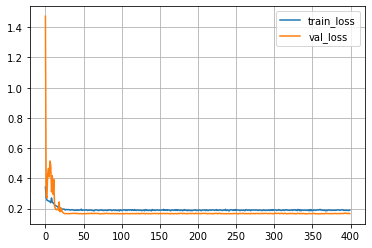

In [28]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

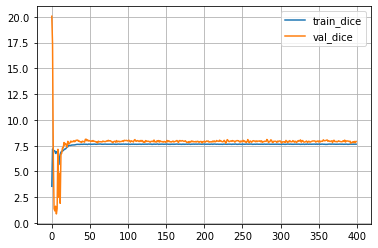

In [29]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.grid()
    plt.show()

In [30]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]
    model.eval()
    with torch.no_grad():
        output = model(sample_val_img)[0]
        pred_mask = torch.argmax(output, axis=0)
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
    ax1.set_title('Image')
    ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
    ax2.set_title('mask')
    ax3.imshow(pred_mask.squeeze().cpu().numpy())
    ax3.set_title('pred_mask')
    plt.show()
    print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor